In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import acr
import spikeinterface.extractors as se
import spikeinterface.core as si
import kdephys.units as ku
import pandas as pd
import numpy as np
import acr.info_pipeline as aip
import tdt
import acr.units as au
import matplotlib.pyplot as plt
plt.style.use('acr_plots.mplstyle')
import xarray as xr
import kdephys.xr as kx
import kdephys.hypno as kh
import ecephys.xrsig.core as xrcss
import pandas_flavor as pf
import kdephys.units.methods
import kdephys.plot as kp

/home/kdriessen/miniconda3/envs/acrdev/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
hyp = {}
hyp['sdpi'] = acr.io.load_hypno('ACR_14', 'sdpi')
hyp['sdpi-bl'] = acr.io.load_hypno('ACR_14', 'sdpi-bl')
hyp['laser1'] = acr.io.load_hypno('ACR_14', 'laser1')
hyp['laser1-bl'] = acr.io.load_hypno('ACR_14', 'laser1-bl')
hyp['swi'] = acr.io.load_hypno('ACR_14', 'swi')
hyp['swi-bl'] = acr.io.load_hypno('ACR_14', 'swi-bl')


In [3]:
d = au.load_spike_dfs('ACR_14')

In [7]:
foo = d['sdpi-NNXr'].copy()

In [11]:
notes = foo.note.values
note_vals = np.unique(notes)

In [16]:
all_vals = [n.split('/') for n in note_vals]

In [26]:
t1 = '2022-10-06T09:01:18.999999000'
t2 = '2022-10-06 10:01:18.999999'
(pd.Timestamp(t2) - pd.Timestamp(t1)).total_seconds()/3600

1.0

In [18]:
np.unique([i for sl in all_vals for i in sl])

array(['bw', 'few', 'merged', 'noisy'], dtype='<U6')

# SDPI - Sleep Deprivation w Photoinhibition

## Experimental Design
![](ref/acr-pd-2.png)

## Basic Firing Rate Plots

<AxesSubplot:title={'left':'SDPI Normalized Firing Rate - Baseline Recording, 5min Rolling Window'}>

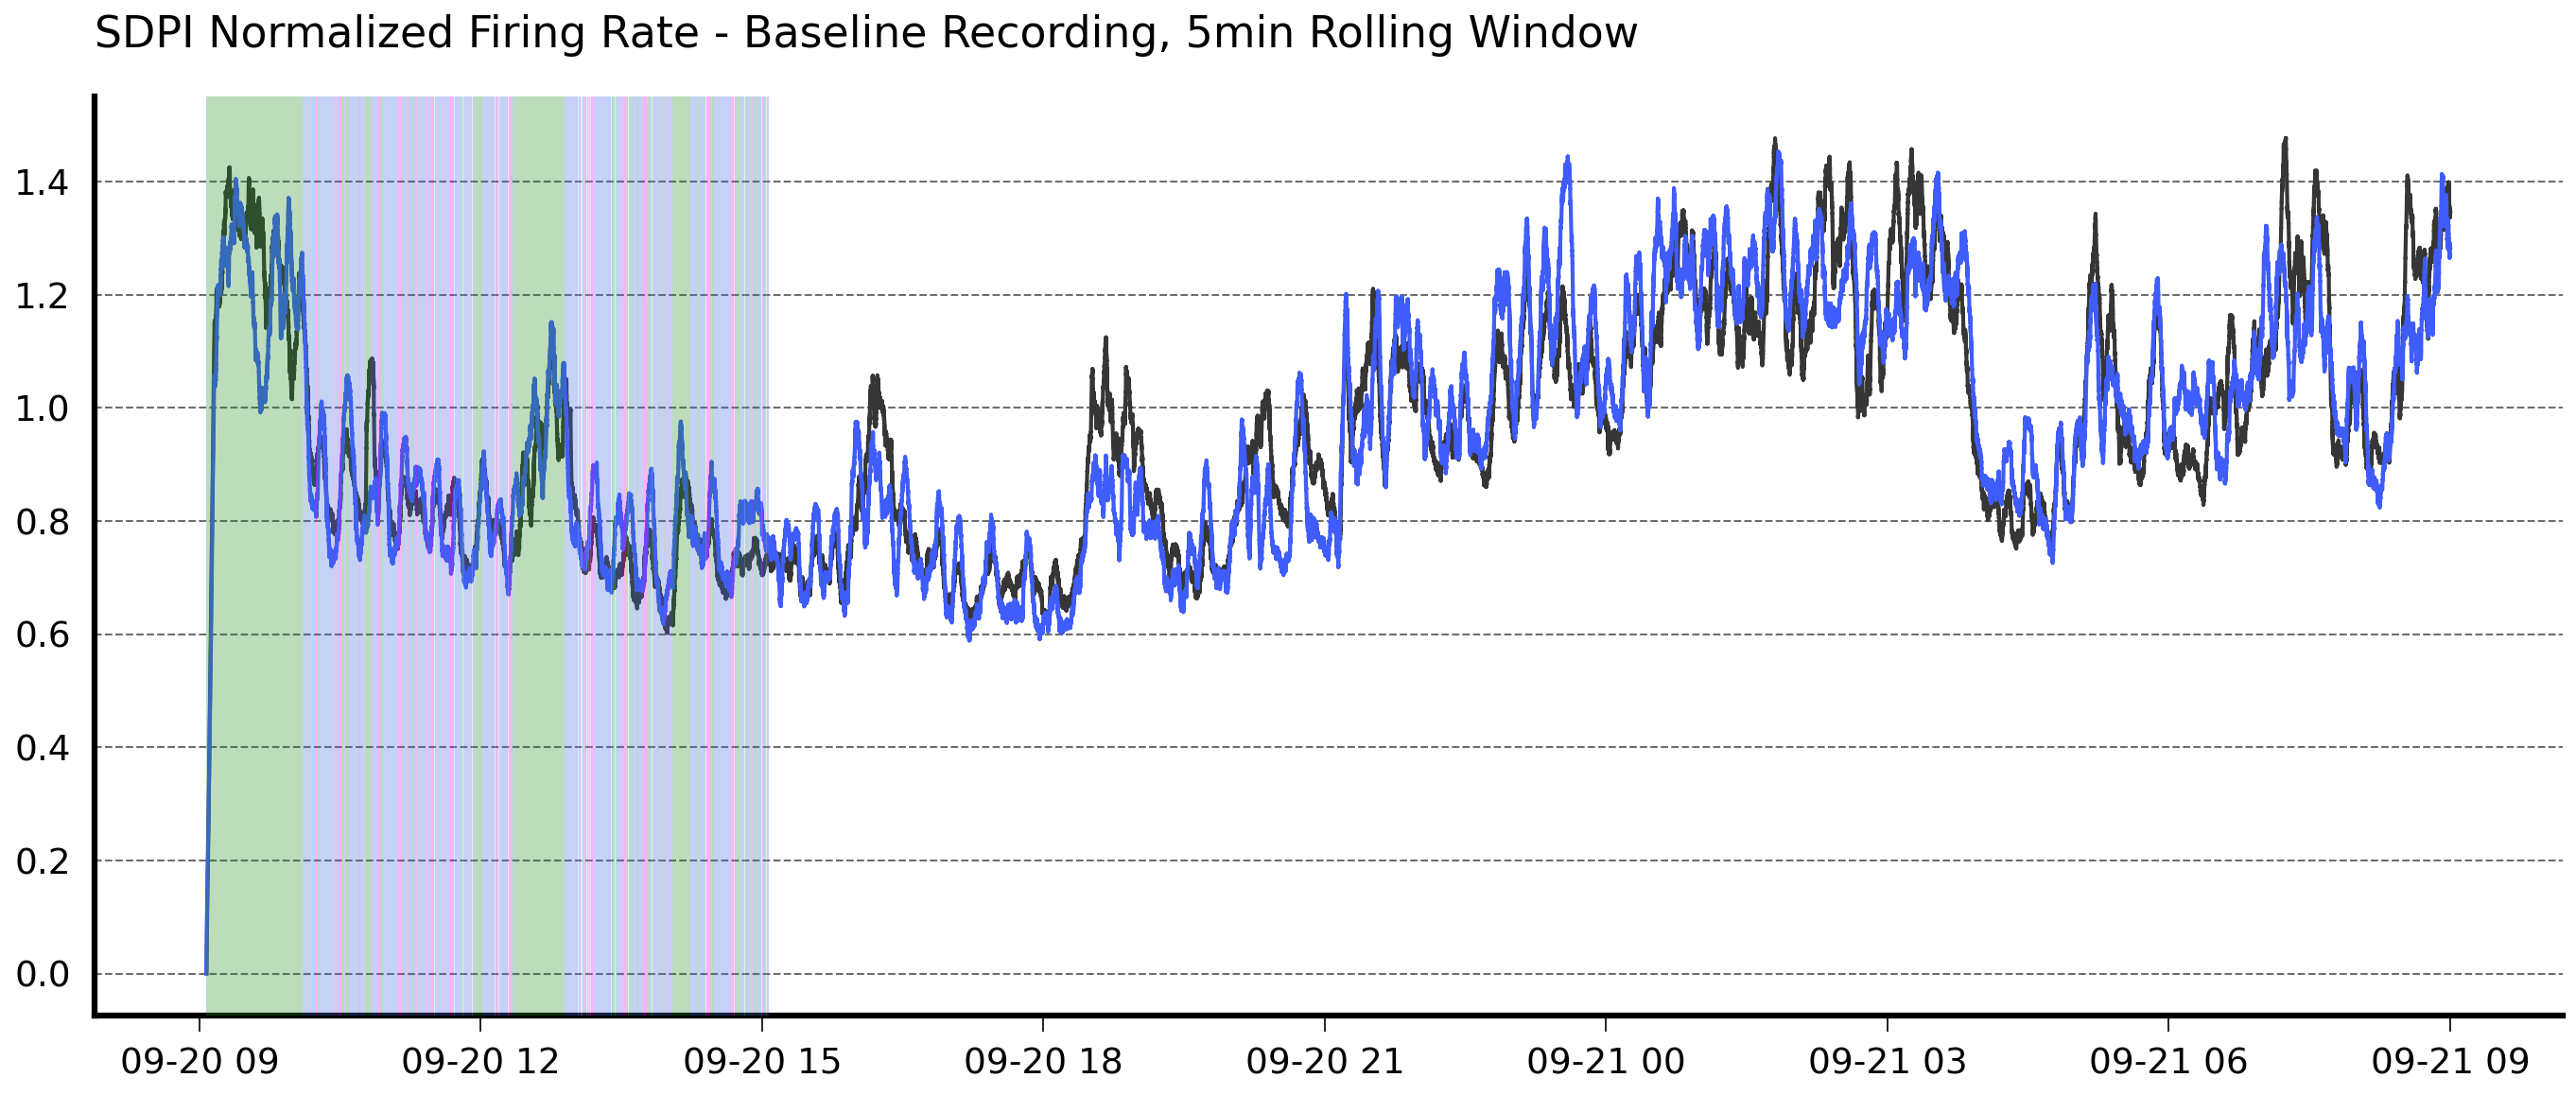

In [16]:
pm = d['sdpi-NNXr'].rec('sdpi-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['sdpi-NNXo'].rec('sdpi-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-20 6:00:00'
t2 = '2022-09-21 9:00:00'
pdata = d['sdpi-NNXr'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['sdpi-NNXo'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(d['sdpi-NNXr'].ts(t1, t2).datetime.values, pdata)
ax.plot(d['sdpi-NNXo'].ts(t1, t2).datetime.values, odata)
ax.set_title('SDPI Normalized Firing Rate - Baseline Recording, 5min Rolling Window')
kp.shade_hypno_for_me(hyp['sdpi-bl'], ax)

<AxesSubplot:title={'left':'SDPI Firing Rate, 60s Rolling Window'}>

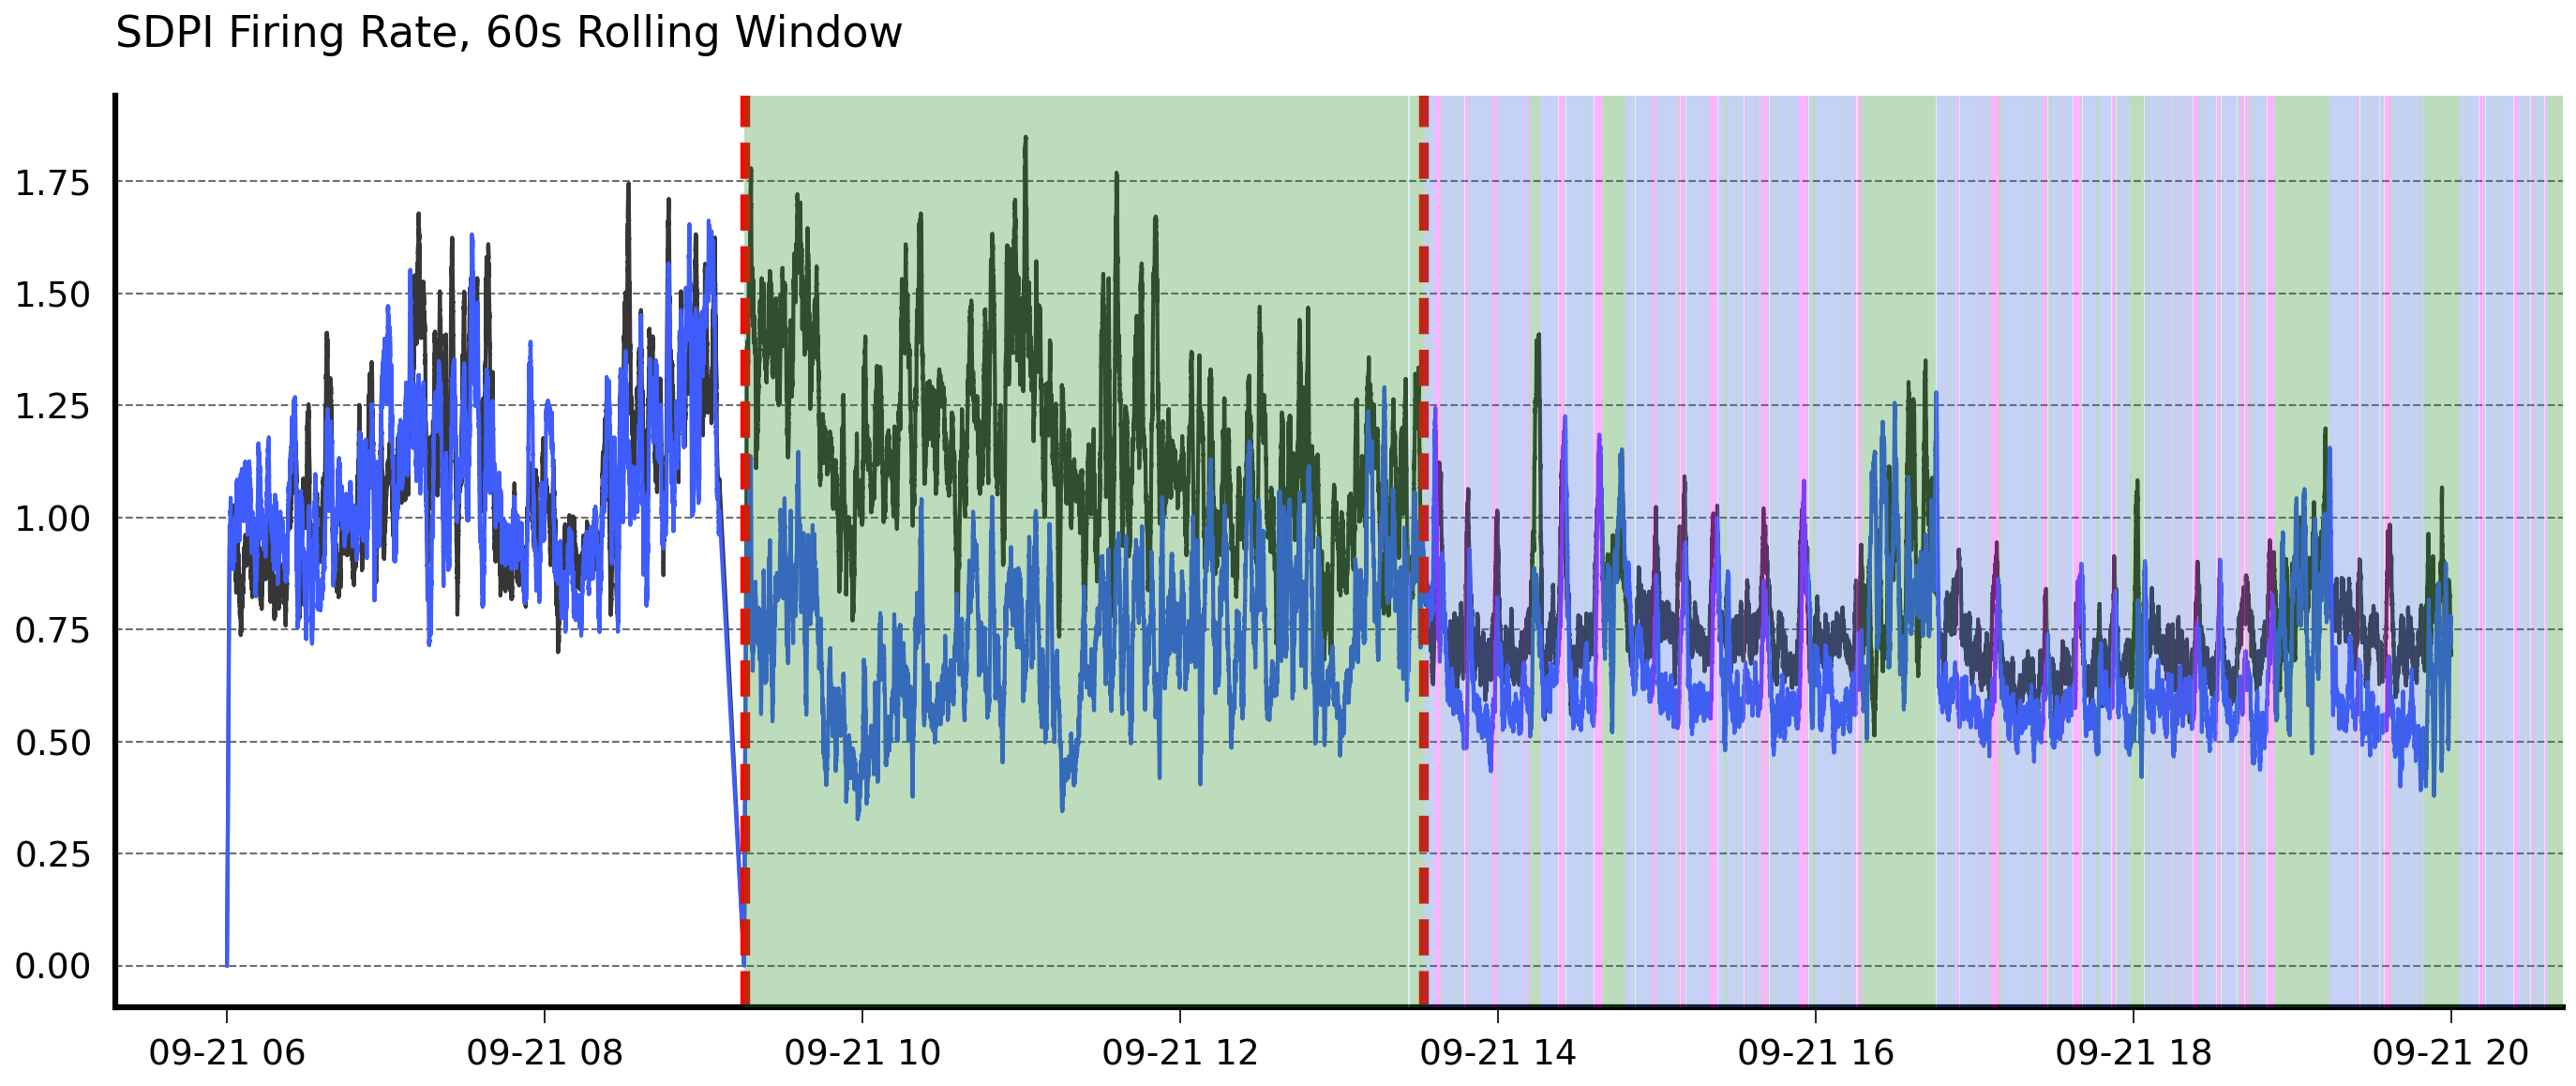

In [15]:
pm = d['sdpi-NNXr'].rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = d['sdpi-NNXo'].rec('sdpi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-21 6:00:00'
t2 = '2022-09-21 20:00:00'
pdata = d['sdpi-NNXr'].ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = d['sdpi-NNXo'].ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(d['sdpi-NNXr'].ts(t1, t2).datetime.values, pdata)
ax.plot(d['sdpi-NNXo'].ts(t1, t2).datetime.values, odata)
stim_borders = d['sdpi-NNXr'].stm().datetime.values.min(), d['sdpi-NNXr'].stm().datetime.values.max()
ax.axvline(stim_borders[0], color='red', linestyle='--', lw=5)
ax.axvline(stim_borders[1], color='red', linestyle='--', lw=5)
ax.set_title('SDPI Firing Rate, 60s Rolling Window')
kp.shade_hypno_for_me(hyp['sdpi'], ax)

# SWI - 'Slow Wave Induction'

## Experimental Design
![](ref/acr-pd-3.png)

## Basic Firing Rate Plots

#todo: some weird stuff happening here

Text(0.0, 1.0, 'SWI-Baseline Normalized Firing Rate, 5min Rolling Window')

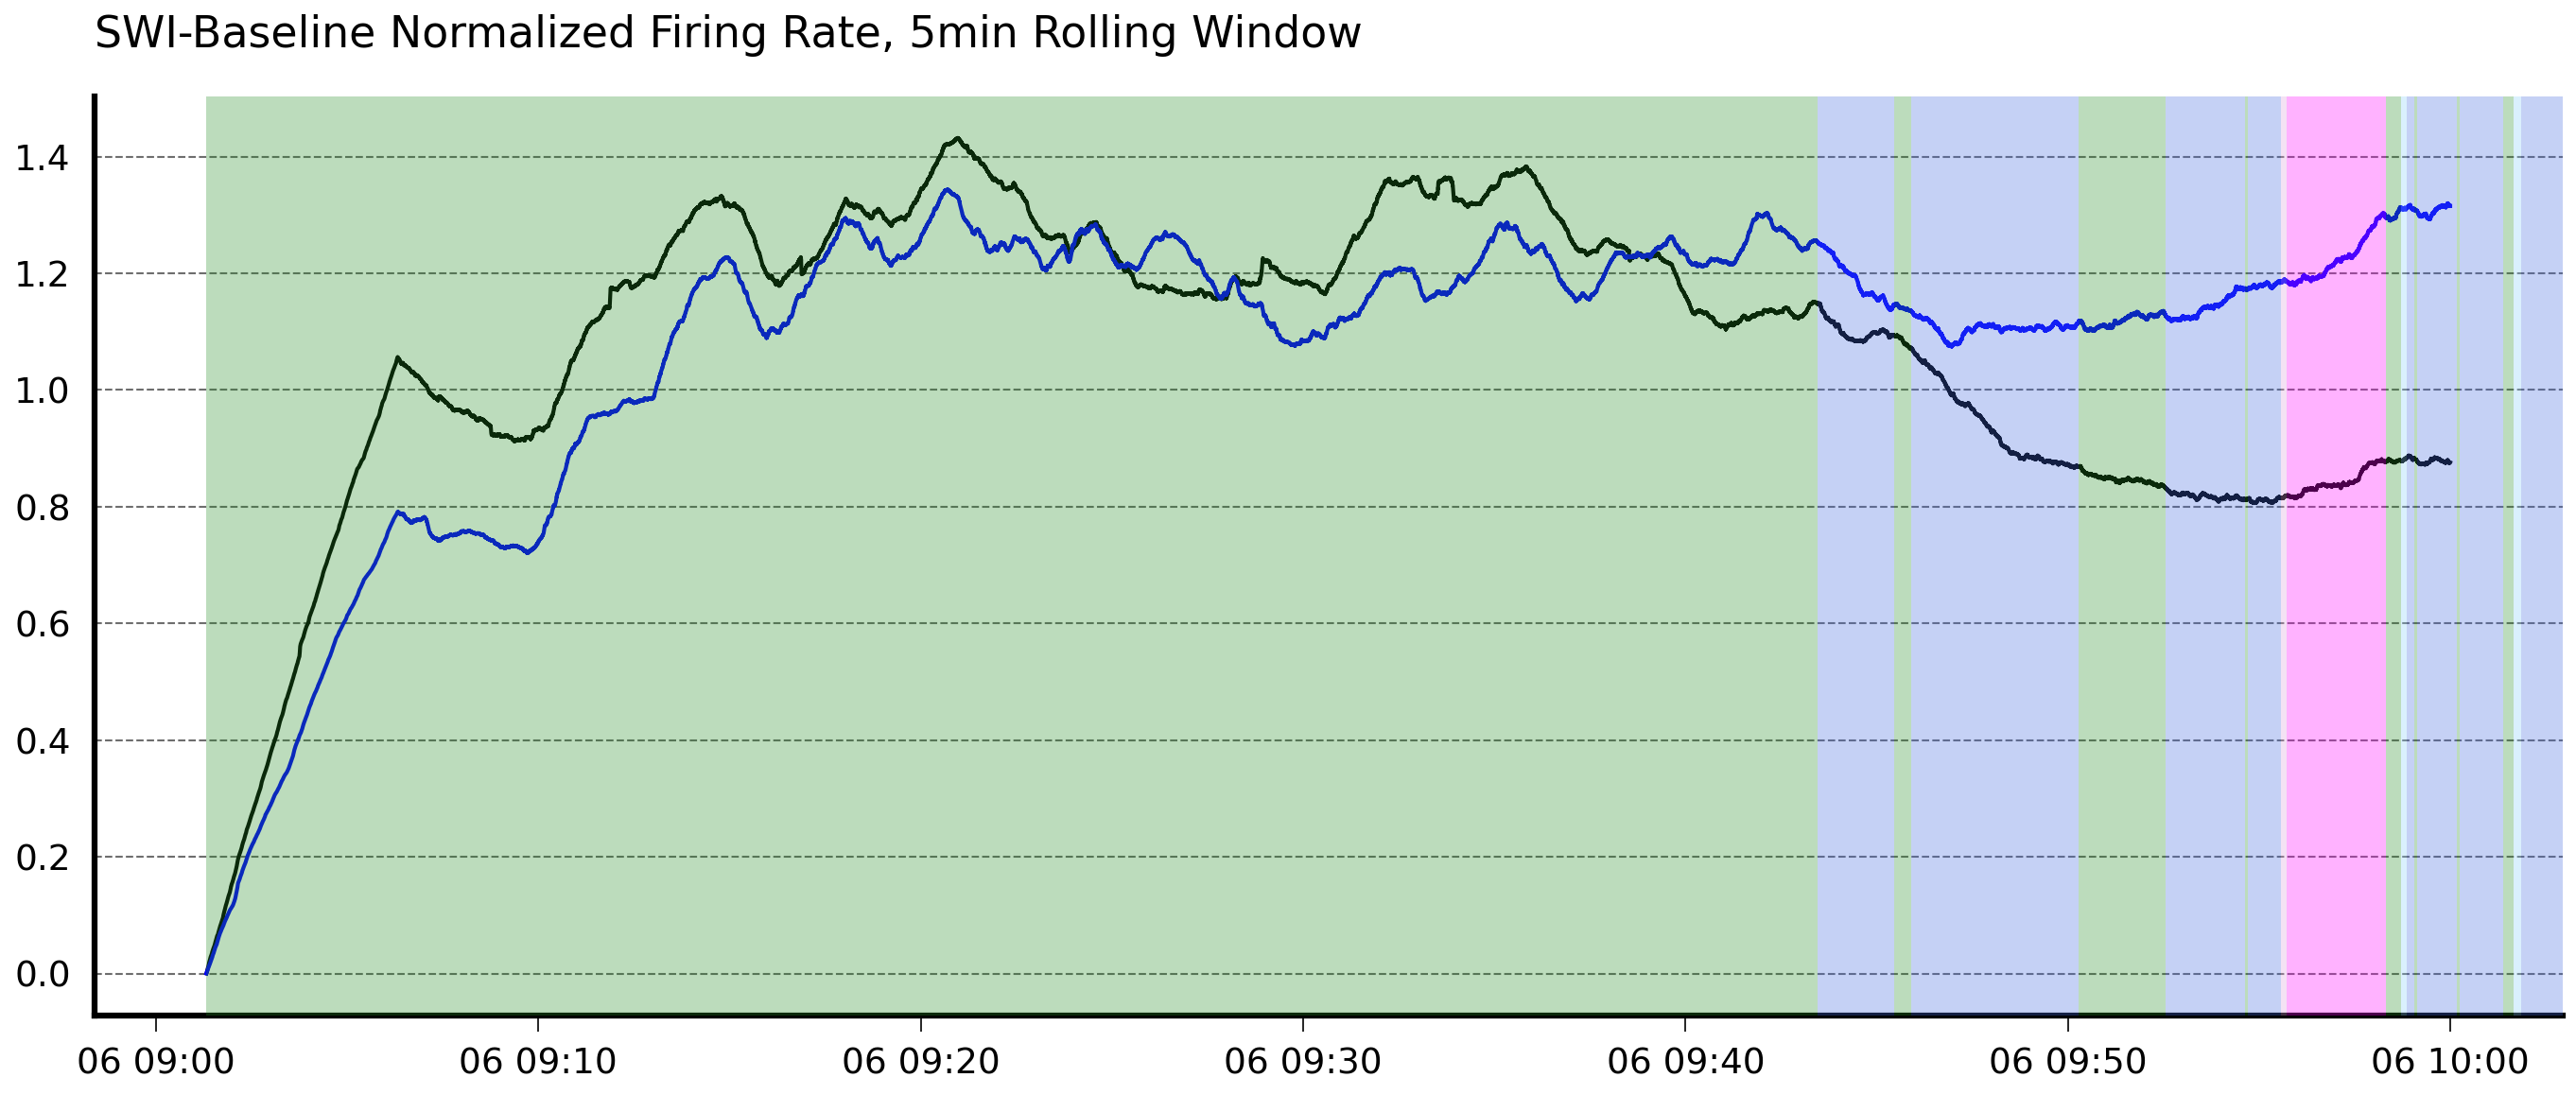

In [4]:
pm = d['swi-NNXr'].rec('swi-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['swi-NNXo'].rec('swi-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-10-06 09:00:00'
t2 = '2022-10-06 10:00:00'
pdata = d['swi-NNXr'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['swi-NNXo'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['swi-NNXr'].ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['swi-NNXo'].ts(t1, t2).datetime.values, odata, color='blue')

stim_borders = d['swi-NNXo'].stm().datetime.values.min(), d['swi-NNXo'].stm().datetime.values.max()
kp.shade_hypno_for_me(hyp['swi-bl'], ax)
ax.set_title('SWI-Baseline Normalized Firing Rate, 5min Rolling Window')

Text(0.0, 1.0, 'SWI-Exp Normalized Firing Rate, 60s Rolling Window')

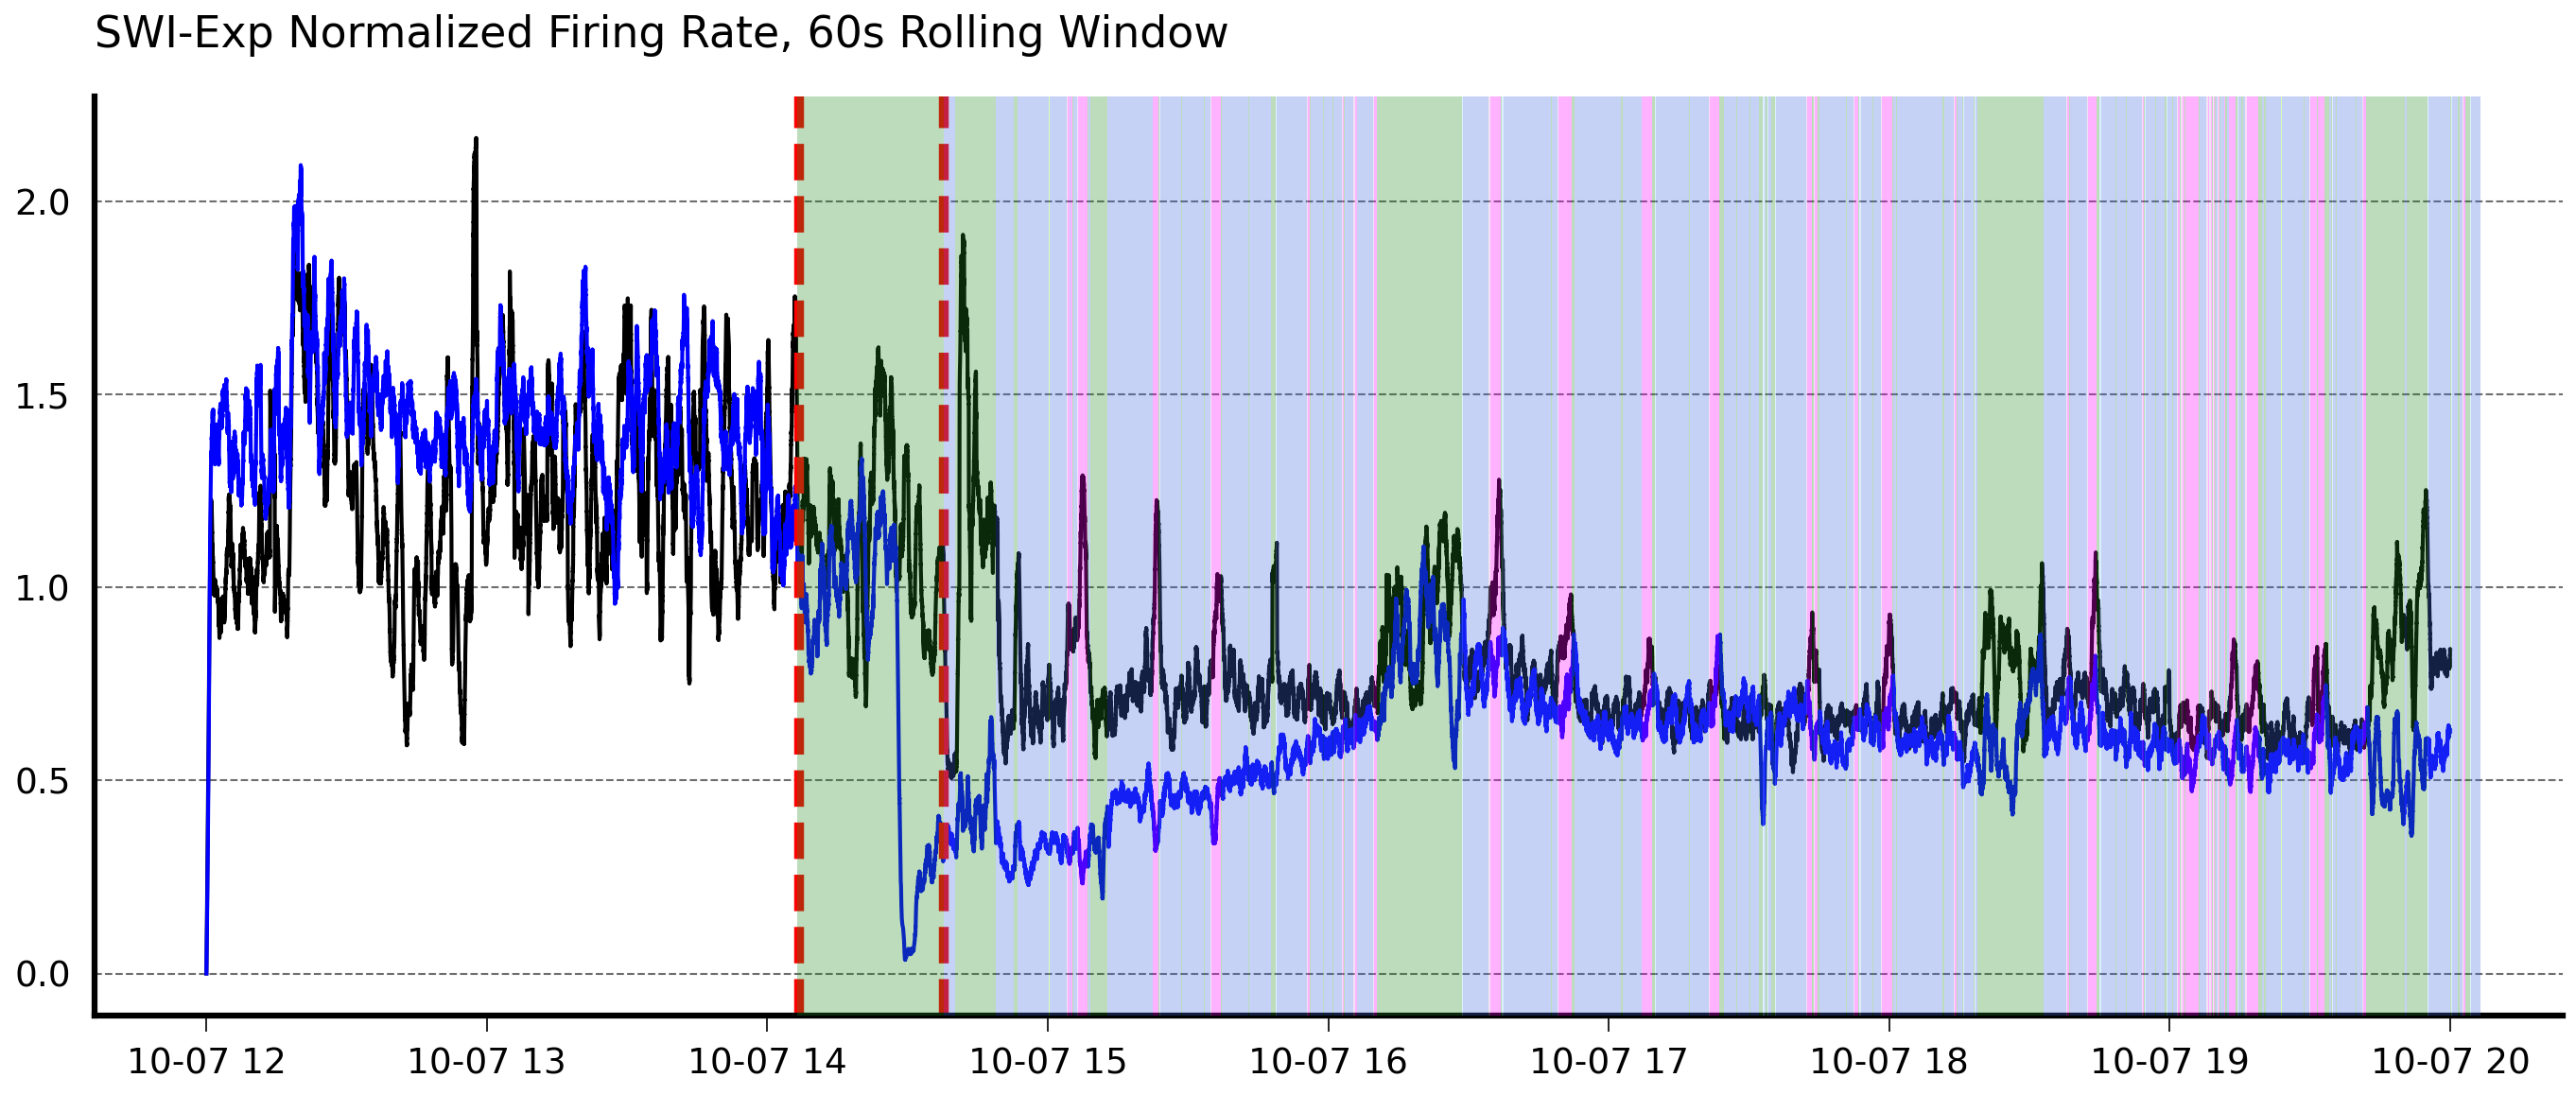

In [23]:
pm = d['swi-NNXr'].rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
om = d['swi-NNXo'].rec('swi-bl').rolling('60s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-10-07 12:00:00'
t2 = '2022-10-07 20:00:00'
pdata = d['swi-NNXr'].ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/pm
odata = d['swi-NNXo'].ts(t1, t2).rolling('60s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['swi-NNXr'].ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['swi-NNXo'].ts(t1, t2).datetime.values, odata, color='blue')

stim_borders = d['swi-NNXo'].stm().datetime.values.min(), d['swi-NNXo'].stm().datetime.values.max()

ax.axvline(stim_borders[0], color='red', linestyle='--', lw=5)
ax.axvline(stim_borders[1], color='red', linestyle='--', lw=5)

kp.shade_hypno_for_me(hyp['swi'], ax)
ax.set_title('SWI-Exp Normalized Firing Rate, 60s Rolling Window')

In [190]:
blo = kh.add_states(bp['swi-bl-NNXo'], hyp['swi-bl'],)
blp = kh.add_states(bp['swi-bl-NNXr'], hyp['swi-bl'])
om = blo.where(blo.state=='NREM', drop=True).delta.mean(dim='datetime')
pm = blp.where(blp.state=='NREM', drop=True).delta.mean(dim='datetime')

In [218]:
swi_rel = {}
swi_rel['NNXo'] = kx.utils.get_smoothed_ds(swi['NNXo']/om)
swi_rel['NNXr'] = kx.utils.get_smoothed_ds(swi['NNXr']/pm)

# Double-SD (laser1)

## Experimental Design
![](ref/acr-pd-1.png)

Text(2022-09-11T07:30:00, 0.3, 'Note: PZ5 malfunction, only have light period of this baseline')

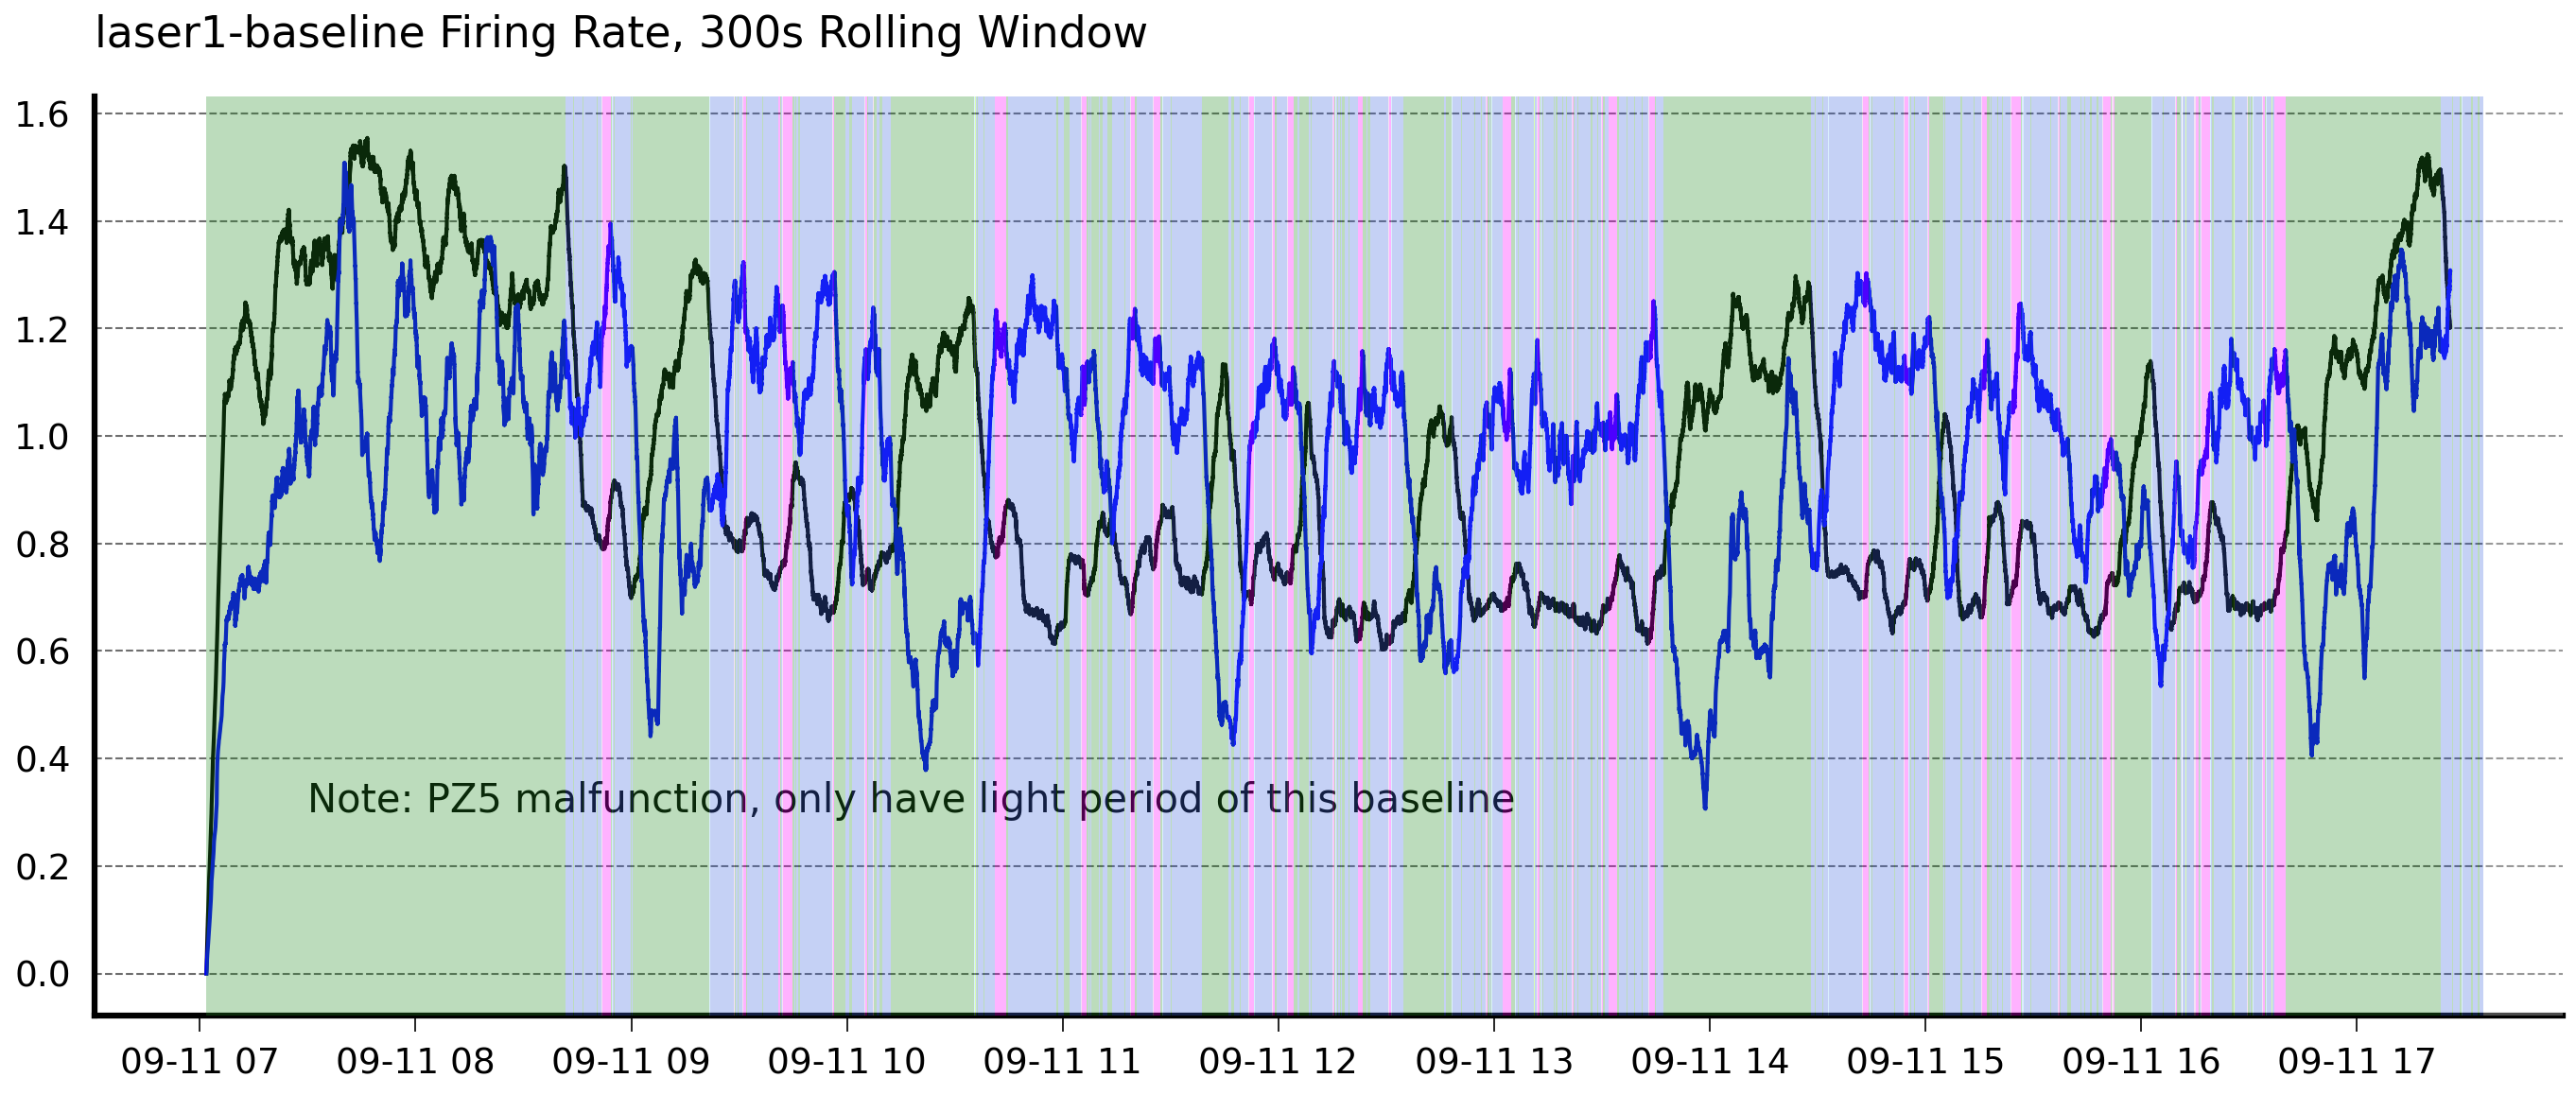

In [33]:
pm = d['laser1-NNXr'].rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['laser1-NNXo'].rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
t1 = '2022-09-11 07:00:00'
t2 = '2022-09-11 19:00:00'
pdata = d['laser1-NNXr'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['laser1-NNXo'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om
f, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(d['laser1-NNXr'].ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['laser1-NNXo'].ts(t1, t2).datetime.values, odata, color='blue')


ax.set_title('laser1-baseline Firing Rate, 300s Rolling Window')
kp.shade_hypno_for_me(hyp['laser1-bl'], ax)
ax.text(np.datetime64('2022-09-11 07:30:00'), 0.3, 'Note: PZ5 malfunction, only have light period of this baseline', color='black', fontsize=20)

<AxesSubplot:title={'left':'laser1-Exp normalized Firing Rate, 300s Rolling Window'}>

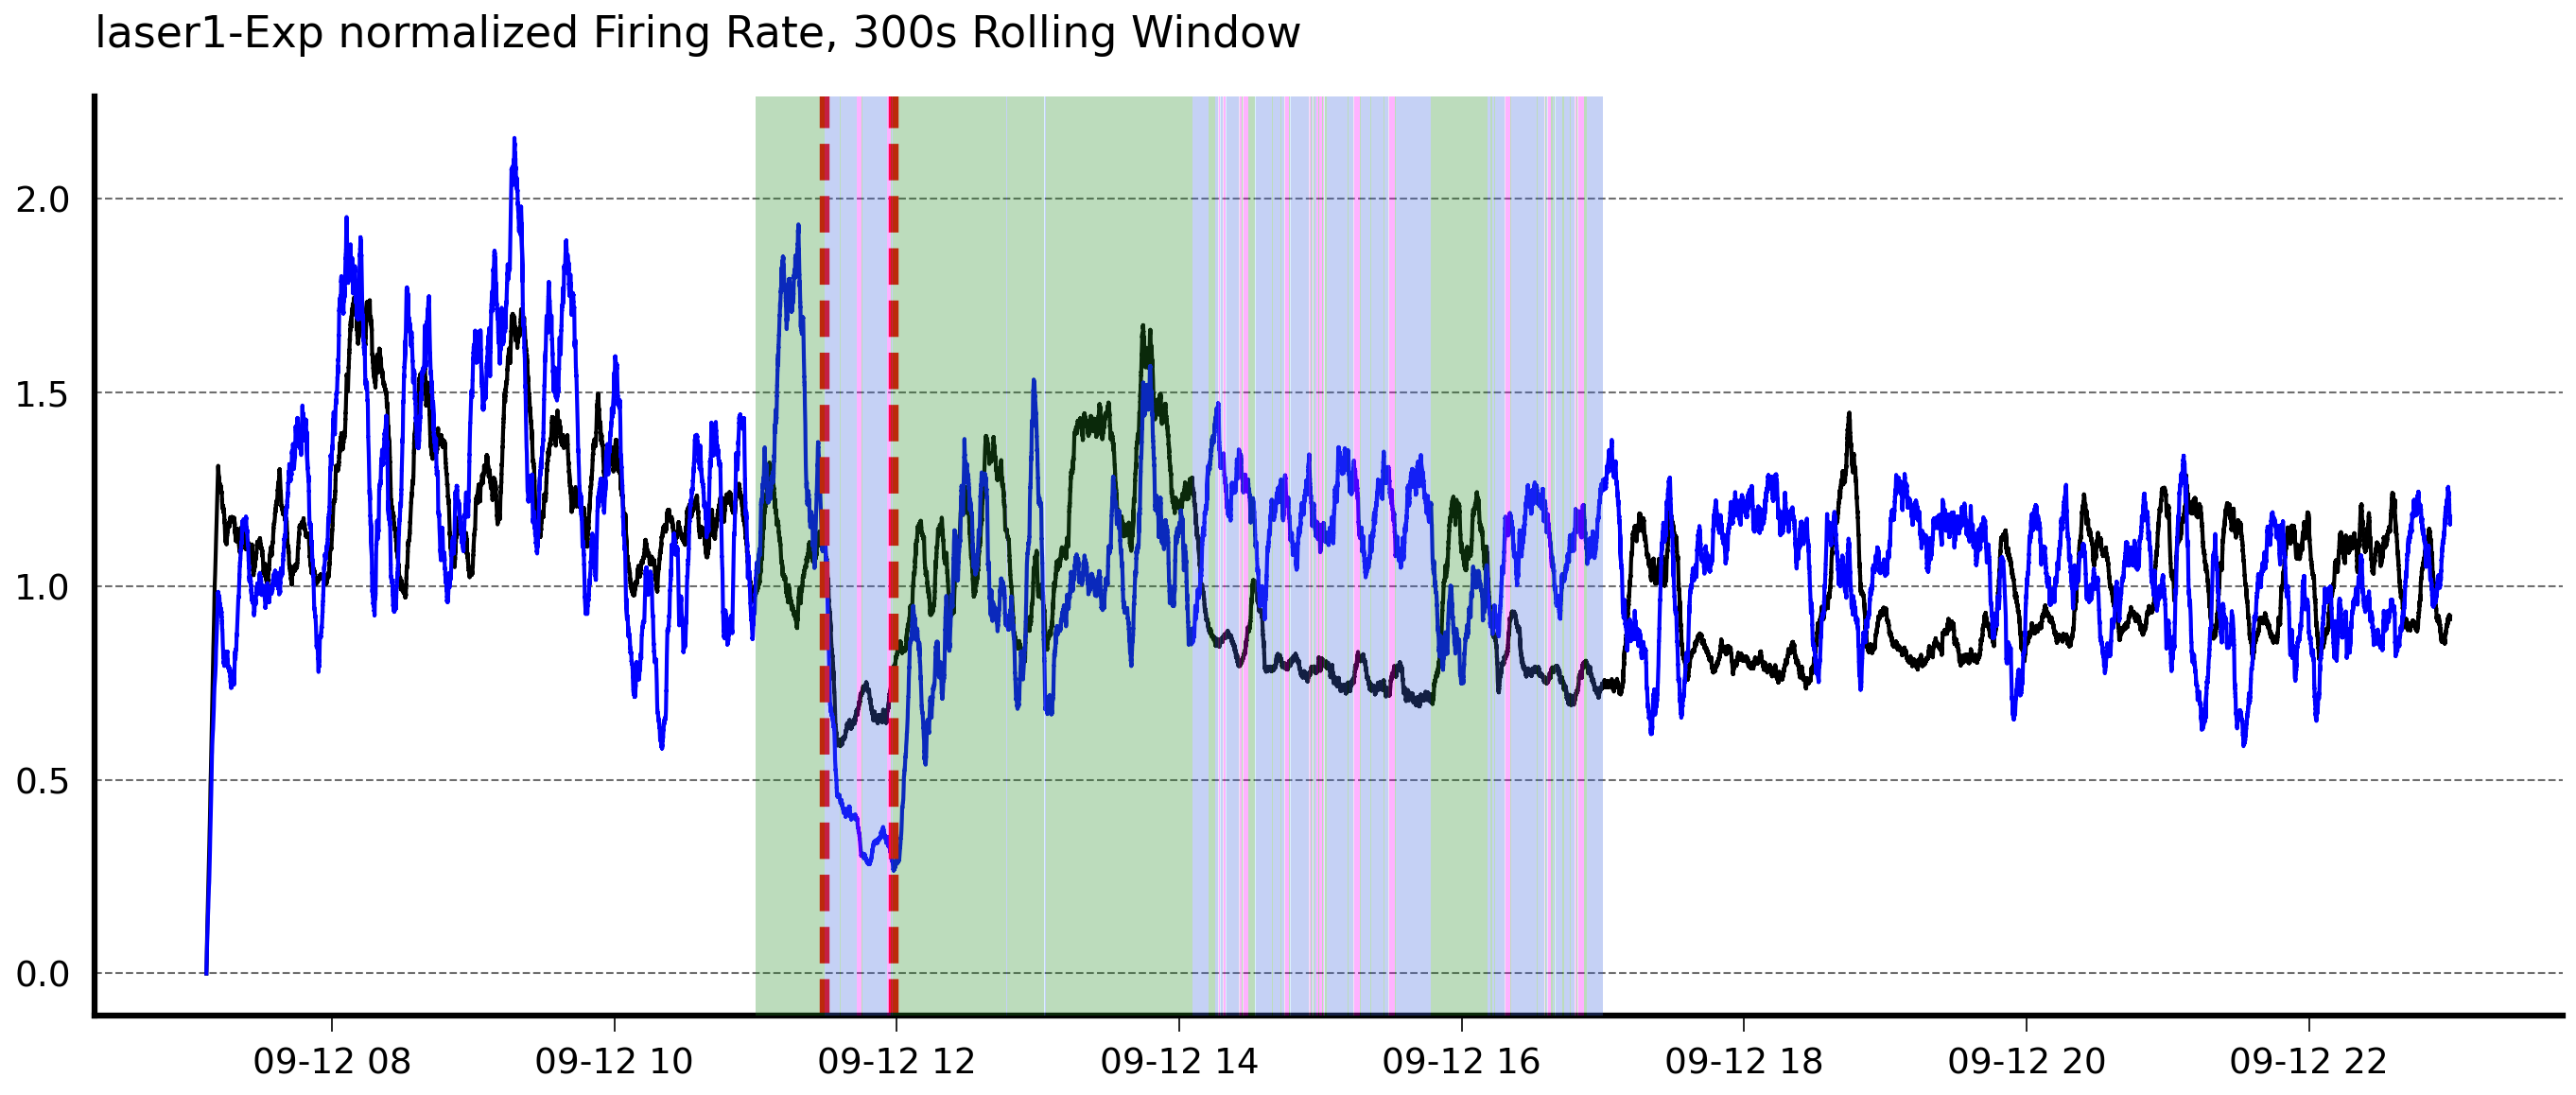

In [35]:
pm = d['laser1-NNXr'].rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()
om = d['laser1-NNXo'].rec('laser1-bl').rolling('300s', on='datetime').count().cluster_id.values.mean()

t1 = '2022-09-12 07:00:00'
t2 = '2022-09-12 23:00:00'
pdata = d['laser1-NNXr'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/pm
odata = d['laser1-NNXo'].ts(t1, t2).rolling('300s', on='datetime').count().cluster_id.values/om

f, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(d['laser1-NNXr'].ts(t1, t2).datetime.values, pdata, color='k')
ax.plot(d['laser1-NNXo'].ts(t1, t2).datetime.values, odata, color='blue')

stim_borders = d['laser1-NNXo'].stm().datetime.values.min(), d['laser1-NNXo'].stm().datetime.values.max()
ax.axvline(stim_borders[0], color='red', linestyle='--', lw=5)
ax.axvline(stim_borders[1], color='red', linestyle='--', lw=5)

ax.set_title('laser1-Exp normalized Firing Rate, 300s Rolling Window')
kp.shade_hypno_for_me(hyp['laser1'], ax)